In [1]:
import data, model, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def print_content_feature_contrib(feature_activations_x, feature_activations_y):
    for key in feature_activations_x:
        feature_loss = torch.nn.functional.mse_loss(feature_activations_x[key], feature_activations_y[key])
        weight = 0.0
        if key in CONTENT_LOSS_WEIGHTS:
            weight = CONTENT_LOSS_WEIGHTS[key]
        weighted_loss = weight * feature_loss
        print("Content layer {} loss: {} weight: {} weighted loss: {}".format(key, feature_loss, weight, weighted_loss))

def print_style_feature_contrib(features_style, features_transformed):
    for key, weight in STYLE_LOSS_WEIGHTS.items():
        Gx = function.gram_matrix(features_style[key])
        Gy = function.gram_matrix(features_transformed[key])
        value = torch.nn.functional.mse_loss(Gx, Gy)
        weighted_value = weight * value
        print(f'Style loss {key} with weight {weight}: {value} weighted loss: {weighted_value}')

In [11]:
def forward(content, style, content_encoder, style_encoder, decoder):
    """ Forwards a batch through the pipeline.
    
    Parameters:
    -----------
    content : torch.Tensor, shape [B, C, H, W]
        The content image.
    style : torch.Tensor, shape [B, C, H', W']
        The style image, usually H' = H and W' = W.
    content_encoder : torch.nn.modules.Module
        Encoder for content images.
    style_encoder : torch.nn.modules.Module
        Encoder for style images.
    decoder : torch.nn.modules.Module
        Decoder that uses AdaIn to decode the content and apply the style.

    Returns:
    --------
    reco : torch.Tensor, shape [B, C, H, W]
        A reconstruction of the content after application of the style.
    style_representation : torch.Tensor, shape [B, D]
        The latent style representation.
    """
    content_representation = content_encoder(content)
    #style_representation = style_encoder(style)
    style_mean, style_std = style_encoder(style)
    transformed_content = function.adain_mean_std(content_representation, style_mean, style_std)
    #transformed_content = function.adain(content_representation, style_representation)
    #reco = decoder(content_representation, style_representation)
    #reco = decoder(transformed_content)
    reco = decoder(content_representation)
    return reco

In [14]:
# Load training and validation dataset for style and content

VAL_PORTION = 0.5
ITERATIONS = 15002
VAL_ITERATIONS = 1
RESOLUTION = 128
STYLE_DIM = 2310
#STYLE_DIM = 38
BATCH_SIZE = 1
#CONTENT_LOSS_WEIGHTS = {'input' : 0.0, 'relu3' : 0.0, 'relu4' : 1e2, 'relu5' : 0.0}
#STYLE_LOSS_WEIGHTS = {'input' : 0.0, 'relu1' : 1e2, 'relu2' : 1e2, 'relu3' : 1e2, 'relu4' : 1e2, 'relu5' : 1e2}

CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 1e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}


data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, mean_std_projection=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in content_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in decoder.parameters():
    trainable_parameters.append(parameter)


optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)


iteration = 0
running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0

content_loss_history_train = []
style_loss_history_train = []
content_loss_history_val = []
style_loss_history_val = []

for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: break
    iteration += 1
    
    content_encoder.train()
    style_encoder.train()
    decoder.train()

    optimizer.zero_grad()
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')

    #content_representation = content_encoder(content_image)
    #style_representation = style_encoder(style_image)

    #transformed_content = function.adain(content_representation, style_representation)
    #transformed = decoder(transformed_content)
    #transformed = decoder(content_representation, style_representation)
    
    transformed = forward(content_image, style_image, content_encoder, style_encoder, decoder)

    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_transformed = loss_net(transformed)

    perceptual_loss = loss.perceptual_loss(features_content, features_transformed, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_transformed, STYLE_LOSS_WEIGHTS)
    
    lambda_content = 1.0
    lambda_style = 1.0

    total_loss = lambda_content * perceptual_loss + lambda_style * style_loss

    total_loss.backward()
    optimizer.step()

    running_perceptual_loss += perceptual_loss.item()
    running_style_loss += style_loss.item()

    running_count += 1

    print(f'\r{iteration:06d} : avg perceptual_loss : {running_perceptual_loss / running_count:.4f}\tavg style loss : {running_style_loss / running_count:.4f}', end='\r')
    content_loss_history_train.append(perceptual_loss.item())
    style_loss_history_train.append(style_loss.item())
    
    if iteration % 5000 == 1:
        torch.save(content_encoder.state_dict(), f'output/content_encoder_{iteration}')
        torch.save(style_encoder.state_dict(), f'output/style_encoder_{iteration}')
        torch.save(decoder.state_dict(), f'output/decoder_{iteration}')

    if iteration % 500 == 1:

        running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0 # After each validation, reset running training losses
        print(f'\nValidating...')

        content_encoder.eval()
        style_encoder.eval()
        decoder.eval()
        perceptual_loss = 0.0
        style_loss = 0.0
        val_iteration = 0

        with torch.no_grad():

            #torch.save(content_image.cpu(), f'output/{iteration}_0_content.pt')
            #torch.save(style_image.cpu(), f'output/{iteration}_0_style.pt')
            #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_0_style_reconstructed.pt')
            #torch.save(decoder(content_representation).cpu(), f'output/{iteration}_0_reconstructed.pt')
            #torch.save(transformed.cpu(), f'output/{iteration}_0_transformed.pt')


            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                val_iteration += 1
                if val_iteration > VAL_ITERATIONS: break

                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')

                #content_representation = content_encoder(content_image)
                #style_representation = style_encoder(style_image)

                #transformed_content = function.adain(content_representation, style_representation)
                #reconstruction = decoder(transformed_content)
                #reconstruction = decoder(content_representation, style_representation)
                
                reconstruction = forward(content_image, style_image, content_encoder, style_encoder, decoder)

                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_reconstruction = loss_net(reconstruction)
                
                #print("------------------------------------------------------------------")
                #print("Features content:")
                #print_content_feature_contrib(features_content, features_reconstruction)
                #print("Features style:")
                #print_style_feature_contrib(features_style, features_reconstruction)
                #print("------------------------------------------------------------------")
                
                perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
                style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)
                    
                torch.save(content_image.cpu(), f'output/{iteration}_{val_iteration}_content.pt')
                torch.save(style_image.cpu(), f'output/{iteration}_{val_iteration}_style.pt')
                torch.save(reconstruction.cpu(), f'output/{iteration}_{val_iteration}_reconstruction.pt')
                #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_{val_iteration}_style_reconstruction.pt')

                print(f'\rValidation {val_iteration:02d} : Perceptual loss {perceptual_loss / val_iteration:.4f}\tStyle loss {style_loss / val_iteration:.4f}', end='\r')
            print('\nValidation done.')
            val_iteration -= 1
            content_loss_history_val.append((iteration, perceptual_loss / val_iteration))
            style_loss_history_val.append((iteration, style_loss / val_iteration))

            torch.save(content_loss_history_train, 'output/content_loss_history_train.pt')
            torch.save(style_loss_history_train, 'output/style_loss_history_train.pt')
            torch.save(content_loss_history_val, 'output/content_loss_history_val.pt')
            torch.save(style_loss_history_val, 'output/style_loss_history_val.pt')
            
            data_loader_val.reset()
            

000001 : avg perceptual_loss : 0.2234	avg style loss : 9.8149
Validating...
Validation 01 : Perceptual loss 0.2229	Style loss 1.2983
Validation done.
000501 : avg perceptual_loss : 0.0717	avg style loss : 0.0770
Validating...
Validation 01 : Perceptual loss 0.0457	Style loss 0.0473
Validation done.
001001 : avg perceptual_loss : 0.0427	avg style loss : 0.0450
Validating...
Validation 01 : Perceptual loss 0.0399	Style loss 0.0439
Validation done.
001501 : avg perceptual_loss : 0.0394	avg style loss : 0.0422
Validating...
Validation 01 : Perceptual loss 0.0389	Style loss 0.0409
Validation done.
002001 : avg perceptual_loss : 0.0378	avg style loss : 0.0405
Validating...
Validation 01 : Perceptual loss 0.0376	Style loss 0.0396
Validation done.
002501 : avg perceptual_loss : 0.0383	avg style loss : 0.0407
Validating...
Validation 01 : Perceptual loss 0.0378	Style loss 0.0402
Validation done.
003001 : avg perceptual_loss : 0.0366	avg style loss : 0.0390
Validating...
Validation 01 : Perceptu

KeyboardInterrupt: 

# Evaluate

In [5]:
CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 5e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}
RESOLUTION = 128
ITERATION = 15001
EVAL_ITERATIONS = 1
BATCH_SIZE = 1

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_loader_style_eval = DataLoader(data_style, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_loader_content_eval = DataLoader(data_content, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_loader_eval = data.DatasetPairIterator(data_loader_content_eval, data_loader_style_eval)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

content_encoder.load_state_dict(torch.load(f'output/content_encoder_{ITERATION}'))
style_encoder.load_state_dict(torch.load(f'output/style_encoder_{ITERATION}'))
decoder.load_state_dict(torch.load(f'output/decoder_{ITERATION}'))

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

content_encoder.eval()
style_encoder.eval()
decoder.eval()

with torch.no_grad():
    eval_iteration = 0

    for (content_image, content_path), (style_image, style_path) in data_loader_eval:
        if eval_iteration >= EVAL_ITERATIONS:
            break

        perceptual_loss = 0.0
        style_loss = 0.0
        eval_iteration += 1

        if torch.cuda.is_available():
            content_image = content_image.to('cuda')
            style_image = style_image.to('cuda')

        #content_representation = content_encoder(content_image)
        #style_representation = style_encoder(style_image)

        #transformed_content = function.adain(content_representation, style_representation)
        #reconstruction = decoder(transformed_content)
        #reconstruction = decoder(content_representation, style_representation)

        reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

        features_content = loss_net(content_image)
        features_style = loss_net(style_image)
        features_reconstruction = loss_net(reconstruction)

        perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
        style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)

        torch.save(content_image.cpu(), f'output/eval_{eval_iteration}_content.pt')
        torch.save(style_image.cpu(), f'output/eval_{eval_iteration}_style.pt')
        torch.save(reconstruction.cpu(), f'output/eval_{eval_iteration}_reconstruction.pt')

        print(f'Evaluation {eval_iteration:02d} : Perceptual loss {perceptual_loss:.4f}\tStyle loss {style_loss:.4f}')


Evaluation 01 : Perceptual loss 0.6691	Style loss 0.2308


# Other

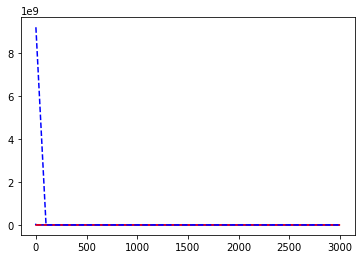

In [5]:
plt.plot(content_loss_history_train[10:], "r")
plt.plot(style_loss_history_train[10:], "b")
plt.plot(*zip(*content_loss_history_val), "r--")
plt.plot(*zip(*style_loss_history_val), "b--")

In [ ]:
image_batch = torch.load("./output/91_9_reconstruction.pt")
image_batch = data.vgg_normalization_undo(image_batch.numpy())
#plt.imshow(transforms.ToPILImage()(image))
image_batch = np.transpose(image_batch, (0, 2, 3, 1))
plt.imshow(image_batch[0])

In [ ]:
def show_images(epoch, iteration):
    content_batch = torch.load("./output/{}_{}_content.pt".format(epoch, iteration))
    style_batch = torch.load("./output/{}_{}_style.pt".format(epoch, iteration))
    reconstruction_batch = torch.load("./output/{}_{}_reconstruction.pt".format(epoch, iteration))
    
    content_batch = data.vgg_normalization_undo(content_batch.numpy())
    style_batch = data.vgg_normalization_undo(style_batch.numpy())
    reconstruction_batch = data.vgg_normalization_undo(reconstruction_batch.numpy())
    
    content_batch = np.transpose(content_batch, (0, 2, 3, 1))
    style_batch = np.transpose(style_batch, (0, 2, 3, 1))
    reconstruction_batch = np.transpose(reconstruction_batch, (0, 2, 3, 1))
    
    fig = plt.figure(figsize=(12, 4))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(content_batch[0])
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(style_batch[0])
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(reconstruction_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


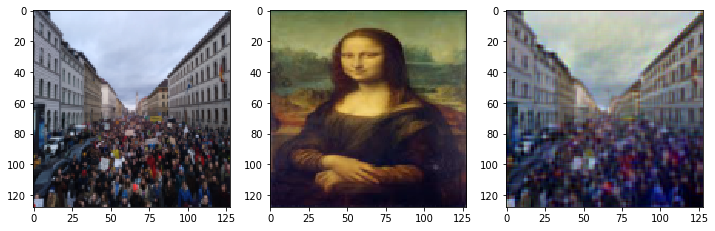

In [7]:
show_images(1101, 1)

In [16]:
print(STYLE_DIM)

2310
